# 7章：質問応答

In [1]:
from datasets import get_dataset_config_names, load_dataset

domains = get_dataset_config_names("subjqa")
domains

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [2]:
subjqa = load_dataset("subjqa", name="electronics")
subjqa["train"]["answers"][1]

Reusing dataset subjqa (/home/ace14385kw/.cache/huggingface/datasets/subjqa/electronics/1.1.0/e5588f9298ff2d70686a00cc377e4bdccf4e32287459e3c6baf2dc5ab57fe7fd)


  0%|          | 0/3 [00:00<?, ?it/s]

{'text': ['Bass is weak as expected',
  'Bass is weak as expected, even with EQ adjusted up'],
 'answer_start': [1302, 1302],
 'answer_subj_level': [1, 1],
 'ans_subj_score': [0.5083333253860474, 0.5083333253860474],
 'is_ans_subjective': [True, True]}

In [3]:
import pandas as pd

dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}

for split, df in dfs.items():
    print(f"Number of questions in {split}: {df['id'].nunique()}")

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


In [4]:
# sampleでランダムな行をサンプリング
qa_cols = ["title", "question", "answers.text", "answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


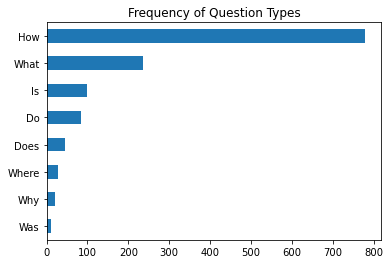

In [5]:
import matplotlib.pyplot as plt

counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
    counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

### MinuLMによるQAシステムの構築

In [6]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("deepset/minilm-uncased-squad2")
question = "How much music can this hold?"
context = "An MP3 is about 1 MB/minute, so about 6000 hours depending on file size."
inputs = tokenizer(question, context, return_tensors="pt")
inputs, tokenizer.decode(inputs["input_ids"][0])

({'input_ids': tensor([[  101,  2129,  2172,  2189,  2064,  2023,  2907,  1029,   102,  2019,
          23378,  2003,  2055,  1015, 16914,  1013,  3371,  1010,  2061,  2055,
          25961,  2847,  5834,  2006,  5371,  2946,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1]])},
 '[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so about 6000 hours depending on file size. [SEP]')

In [7]:
import torch
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained("deepset/minilm-uncased-squad2")

with torch.no_grad():
    outputs = model(**inputs)
outputs # QA向けの出力形式であることが確認できる

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750, -5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3107, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623, -5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0161, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None, attentions=None)

In [8]:
import torch

start_logits = outputs.start_logits
end_logits = outputs.end_logits

start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits) + 1
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
answer

'6000 hours'

In [9]:
from transformers import pipeline

pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)
pipe(question=question, context=context, topk=3)

/home/ace14385kw/anaconda3/lib/python3.9/site-packages/transformers/pipelines/question_answering.py:189: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.2651613652706146, 'start': 38, 'end': 48, 'answer': '6000 hours'},
 {'score': 0.2208300232887268,
  'start': 16,
  'end': 48,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.1025354415178299,
  'start': 16,
  'end': 27,
  'answer': '1 MB/minute'}]

In [10]:
# スライディングウィンドウ戦略による長い入力への対処
example = dfs["train"].iloc[0][["question", "context"]]
tokenized_example = tokenizer(example["question"], example["context"], return_overflowing_tokens=True, max_length=100, stride=25)

for idx, window in enumerate(tokenized_example["input_ids"]):
    print(f"Window #{idx} has {len(window)} tokens")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Window #0 has 100 tokens
Window #1 has 88 tokens


### Haystackを用いたQAパイプラインの構築

In [11]:
url = """https://artifacts.elastic.co/downloads/elasticsearch/\
elasticsearch-7.9.2-linux-x86_64.tar.gz"""
!wget -nc -q {url}
!tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
# Elasticsearchの起動
import os
from subprocess import Popen, PIPE, STDOUT

!chown -R daemon:daemon elasticsearch-7.9.2
es_server = Popen(args=['elasticsearch-7.9.2/bin/elasticsearch'], stdout=PIPE, stderr=STDOUT, preexec_fn=lambda: os.setuid(1))
!sleep 30

In [ ]:
from haystack.document_stores import ElasticsearchDocumentStore

document_store = ElasticsearchDocumentStore(return_embedding=True)

for split, df in dfs.items():
    # 重複レビューの除去
    docs = [{"text": row["context"],
            "meta":{"item_id": row["title"], "question_id": row["id"], "split": split}}
        for _, row in df.drop_duplicates(subset="context").iterrows()]
    document_store.write_documents(docs, index="document")

document_store.get_document_count()

In [16]:
from haystack.retriever.sparse import ElasticsearchRetriever

es_retriever = ElasticsearchRetriever(document_store=document_store)

NameError: name 'document_store' is not defined

In [ ]:
from haystack.reader.farm import FARMReader

max_seq_length, doc_stride = 384, 128
reader = FARMReader(model_name_or_path="deepset/minilm-uncased-squad2", progress_bar=False, max_seq_len=max_seq_length, doc_stride=doc_stride, return_no_answer=True)

In [ ]:
# パイプラインによるコンポーネントの組み合わせ
from haystack.pipeline import ExtractiveQAPipeline

pipe = ExtractiveQAPipeline(reader, es_retriever)

In [ ]:
item_id = "B0074BW614"
query = "Is it good for reading?"
preds = pipe.run(query=query, top_k_retriever=3, top_k_reader=3, filters={"item_id": [item_id], "split": ["train"]})

print(f"Question: {preds['query']} \n")
for idx in range(3):
    print(f"Answer {idx+1}: {preds['answers'][idx]['answer']}")
    print(f"Review snippet: ...{preds['answers'][idx]['context']}...")
    print("\n\n")

### QAパイプラインの改善

In [ ]:
class PipelineNode:
    def __init__(self):
        self.outgoing_edges = 1
    
    def run(self, **kwargs):
        ...
        return (outputs, "outgoing_edge_name")

In [ ]:
# Retriever評価ノードの作成
from haystack.pipeline import Pipeline
from haystack.eval import EvalDocuments

class EvalRetrieverPipeline:
    def __init__(self, retriever):
        self.retriever = retriever
        self.eval_retriever = EvalDocuments()
        pipe = Pipeline()
        pipe.add_node(component=self.retriever, name="ESRetriever", inputs=["Query"])
        pipe.add_node(component=self.eval_retriever, name="EvalRetriever", inputs=["ESRetriever"]) # 直前のノード名をinputsに指定
        self.pipeline = pipe

pipe = EvalRetrieverPipeline(es_retriever)

In [ ]:
from haystack import Label

labels = []
for i, row in dfs["test"].iterrows():
    # Retrieverのフィルタリングに使うメタデータ
    meta = {"item_id": row["title"], "question_id": row["id"]}
    # 回答のある質問のラベルを追加
    if len(row["answers.text"]):
        for answer in row["answers.text"]:
            label = Label(
                question=row["question"], answer=answer, id=i, origin=row["id"],
                meta=meta, is_correct_answer=True, is_correct_document=True,
                no_answer=False)
            labels.append(label)
    # 回答のない質問のラベルを追加
    else:
        label = Label(
            question=row["question"], answer="", id=i, origin=row["id"],
            meta=meta, is_correct_answer=True, is_correct_document=True,
            no_answer=True)  
        labels.append(label)

# Elasticsearchに書き込み
document_store.write_labels(labels, index="label")

# 一意なIDに関連するすべての質問-回答のペアを集約
labels_agg = document_store.get_all_labels_aggregated(index="label", open_domain=True, aggregate_by_meta=["item_id"]) 

In [ ]:
def run_pipeline(pipeline, top_k_retriever=10, top_k_reader=4):
    for l in labels_agg:
        _ = pipeline.pipeline.run(
            query=l.question,
            top_k_retriever=top_k_retriever,
            top_k_reader=top_k_reader,
            top_k_eval_documents=top_k_retriever,    
            labels=l,
            filters={"item_id": [l.meta["item_id"]], "split": ["test"]})

In [ ]:
# 評価と描画
def evaluate_retriever(retriever, topk_values = [1,3,5,10,20]):
    topk_results = {}

    for topk in topk_values:
        # Create Pipeline
        p = EvalRetrieverPipeline(retriever)
        # Loop over each question-answers pair in test set
        run_pipeline(p, top_k_retriever=topk)
        # Get metrics
        topk_results[topk] = {"recall": p.eval_retriever.recall}
        
    return pd.DataFrame.from_dict(topk_results, orient="index")

def plot_retriever_eval(dfs, retriever_names):
    fig, ax = plt.subplots()
    for df, retriever_name in zip(dfs, retriever_names):
        df.plot(y="recall", ax=ax, label=retriever_name)
    plt.xticks(df.index)
    plt.ylabel("Top-k Recall")
    plt.xlabel("k")
    plt.show()

es_topk_df = evaluate_retriever(es_retriever)
plot_retriever_eval([es_topk_df], ["BM25"])

In [ ]:
 # DPRの使用
from haystack.retriever.dense import DensePassagaRetriever

dpr_retriever = DensePassagaRetriever(document_store=document_store,
    query_embedding_model="facebook/dpr-question_encoder-single-nq-base",
    passage_embedding_model="facebook/dpr-ctx_encoder-single-nq-base", embed_title=False)

# 埋め込み表現の更新
document_store.update_embeddings(retriever=dpr_retriever)

# 評価と描画
dpr_topk_df = evaluate_retriever(dpr_retriever)
plot_retriever_eval([es_topk_df, dpr_topk_df], ["BM25", "DPR"])

In [24]:
# Readerの評価
from farm.evaluation.squad_evaluation import compute_f1, compute_exact

pred = "about 6000 hours"
label = "6000 hours"
compute_exact(label, pred), compute_f1(label, pred)

(0, 0.8)

In [ ]:
from haystack.eval import EvalAnswers

def evaluate_reader(reader):
    score_keys = ["top_1_em", "top_1_f1"]
    eval_reader = EvalAnswers(skip_incorrect_retrieval=False)
    pipe = Pipeline()
    pipe.add_node(component=reader, name="QAReader", inputs=["Query"])
    pipe.add_node(component=eval_reader, name="EvalReader", inputs=["QAReader"])

    for l in labels_agg:
        doc = document_store.query(l.question, 
                                   filters={"question_id":[l.origin]})
        _ = pipe.run(query=l.question, documents=doc, labels=l)
                
    return {k:v for k,v in eval_reader.__dict__.items() if k in score_keys}

reader_eval = {}
reader_eval["Fine-tune on SQuAD"] = evaluate_reader(reader)

In [ ]:
def plot_reader_eval(reader_eval):
    fig, ax = plt.subplots()
    df = pd.DataFrame.from_dict(reader_eval)
    df.plot(kind="bar", ylabel="Score", rot=0, ax=ax)
    ax.set_xticklabels(["EM", "F1"])
    plt.legend(loc='upper left')
    plt.show()

plot_reader_eval(reader_eval)

In [ ]:
def create_paragraphs(df):
    paragraphs = []
    id2context = dict(zip(df["review_id"], df["context"]))
    for review_id, review in id2context.items():
        qas = []
        # Filter for all question-answer pairs about a specific context
        review_df = df.query(f"review_id == '{review_id}'")
        id2question = dict(zip(review_df["id"], review_df["question"]))
        # Build up the qas array
        for qid, question in id2question.items():
            # Filter for a single question ID
            question_df = df.query(f"id == '{qid}'").to_dict(orient="list")
            ans_start_idxs = question_df["answers.answer_start"][0].tolist()
            ans_text = question_df["answers.text"][0].tolist()
            # Fill answerable questions
            if len(ans_start_idxs):
                answers = [
                    {"text": text, "answer_start": answer_start}
                    for text, answer_start in zip(ans_text, ans_start_idxs)]
                is_impossible = False
            else:
                answers = []
                is_impossible = True
            # Add question-answer pairs to qas
            qas.append({"question": question, "id": qid, 
                        "is_impossible": is_impossible, "answers": answers})
        # Add context and question-answer pairs to paragraphs
        paragraphs.append({"qas": qas, "context": review})
    return paragraphs

product = dfs["train"].query("title == 'B00001P4ZH'")
create_paragraphs(product)

In [ ]:
import json

def convert_to_squad(dfs):
    for split, df in dfs.items():
        subjqa_data = {}
        # Create `paragraphs` for each product ID
        groups = (df.groupby("title").apply(create_paragraphs)
            .to_frame(name="paragraphs").reset_index())
        subjqa_data["data"] = groups.to_dict(orient="records")
        # Save the result to disk
        with open(f"electronics-{split}.json", "w+", encoding="utf-8") as f:
            json.dump(subjqa_data, f)
            
convert_to_squad(dfs)

In [ ]:
train_filename = "electronics-train.json"
dev_filename = "electronics-validation.json"

reader.train(data_dir=".", use_gpu=True, n_epochs=1, batch_size=16,
             train_filename=train_filename, dev_filename=dev_filename)

In [ ]:
reader_eval["Fine-tune on SQuAD + SubjQA"] = evaluate_reader(reader)
plot_reader_eval(reader_eval)

In [ ]:
minilm_ckpt = "microsoft/MiniLM-L12-H384-uncased"
minilm_reader = FARMReader(model_name_or_path=minilm_ckpt, progress_bar=False,
                           max_seq_len=max_seq_length, doc_stride=doc_stride,
                           return_no_answer=True)

minilm_reader.train(data_dir=".", use_gpu=True, n_epochs=1, batch_size=16,
             train_filename=train_filename, dev_filename=dev_filename)

In [ ]:
reader_eval["Fine-tune on SubjQA"] = evaluate_reader(minilm_reader)
plot_reader_eval(reader_eval)

In [ ]:
# QAパイプライン全体の評価
# Initialize retriever pipeline
pipe = EvalRetrieverPipeline(es_retriever)
# Add nodes for reader
eval_reader = EvalAnswers()
pipe.pipeline.add_node(component=reader, name="QAReader", 
              inputs=["EvalRetriever"])
pipe.pipeline.add_node(component=eval_reader, name="EvalReader", 
              inputs=["QAReader"])
# Evaluate!
run_pipeline(pipe)
# Extract metrics from reader
reader_eval["QA Pipeline (top-1)"] = {
    k:v for k,v in eval_reader.__dict__.items()
    if k in ["top_1_em", "top_1_f1"]}